# DS405 Machine Learning Applications in Business and Economics Mini-Project
---

<font color="red">TBD: 
- What features to use? 
    - Construct new ones? 
    - Simply leave out all non-numeric features? 
    - Delivery-Delay might be interesting
    - Delivery Delay

- What is the goal of our model?
    - Avoid false negatives? This way returning customers will not receive a voucher. 

</font>


## Introduction

In the realm of e-commerce, a common observation is that a significant proportion of customers engage in a single transaction and then cease further purchases. This phenomenon can be attributed to a multitude of factors. To mitigate this, e-commerce platforms employ a variety of strategies aimed at fostering customer loyalty. One such strategy involves the distribution of discount vouchers subsequent to the initial purchase, with the goal of incentivizing repeat transactions. However, indiscriminate distribution of these vouchers may not be an optimal strategy. This is because a segment of customers might have engaged in repeat purchases even in the absence of such incentives. Consequently, the redemption of these vouchers by such customers translates into a reduction in the retailer’s profit. Empirical analyses conducted by the media retailer have demonstrated that for 10% of non-buyers, the voucher instigates a purchase with an average order value of €20. Thus, if a voucher is dispatched to a customer who would not have actually made another purchase, the revenue increases by an average of €1.5. On the other hand, sending a voucher to a customer who would have made a purchase anyway results in a revenue loss equivalent to the voucher value of €5. For customers who don’t receive a voucher, there is no impact on revenues. Therefore, it is crucial to devise a more targeted approach for the distribution of these vouchers.

## Task 

The task at hand involves constructing a predictive model that leverages various features associated with a customer’s initial order. The objective is to determine whether a €5.00 voucher should be issued to a specific customer. Detailed descriptions of these features can be found in the data dictionary.pdf file.
The model should be designed to predict if a customer will place a subsequent order within a 90-day period following their initial purchase. This information is represented by the target90 variable in the dataset. The model’s performance is evaluated based on the expected revenue across all customers in a given dataset. This is computed by considering the model’s predictions in conjunction with the associated costs and revenues. It’s crucial to note that the model’s effectiveness is directly tied to its ability to maximize this expected revenue. Hence, the model should be optimized with this specific goal in mind.


---

In [1]:
# Import necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier # Binary dependent variable
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from datetime import datetime
from xgboost import XGBClassifier
import joblib # to save trained model 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier

### Step 1: Reading in and getting an overview of the data

In [2]:
# Separator is ;
data = pd.read_csv("train.csv", sep = ";")

# Dataset is wide, print all rows and only first 15 columns
data.describe().iloc[:,0:15]

C:\Users\benny\AppData\Local\Temp\ipykernel_9964\544976364.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("train.csv", sep = ";")


,customernumber,salutation,title,domain,newsletter,model,paymenttype,deliverytype,invoicepostcode,voucher,case,numberitems,gift,entry,points
count,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.0
mean,33389.298569,0.541569,0.006969,7.517115,0.169483,1.646910,1.000987,0.201955,48.752282,0.162020,2.934378,2.019551,0.004564,0.414642,0.0
std,19148.090449,0.657044,0.083192,3.683945,0.375184,0.825981,1.092677,0.401465,24.361425,0.368475,1.319270,1.726046,0.067404,0.492668,0.0
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0
25%,16802.750000,0.000000,0.000000,4.000000,0.000000,1.000000,0.000000,0.000000,30.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.0
50%,33552.500000,0.000000,0.000000,9.000000,0.000000,1.000000,1.000000,0.000000,47.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.0
75%,50034.250000,1.000000,0.000000,11.000000,0.000000,2.000000,2.000000,0.000000,66.000000,0.000000,4.000000,2.000000,0.000000,1.000000,0.0
max,66251.000000,2.000000,1.000000,12.000000,1.000000,3.000000,3.000000,1.000000,99.000000,1.000000,5.000000,50.000000,1.000000,1.000000,0.0


In [3]:
# Second half of the columns
# Dataset is wide, print all rows and only remaining columns
data.describe().iloc[:,15:]

,shippingcosts,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
count,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000
mean,0.150611,637.920809,0.059979,0.061613,0.068860,0.902122,0.404342,0.276644,0.018903,0.047027,0.180986,0.027908,0.023128,0.000185,0.164981,0.092883,0.186598
std,0.357674,724.358131,0.388740,0.306833,0.474444,1.654767,1.410395,1.353981,0.253596,0.434265,0.561751,0.299862,0.401782,0.013601,0.836705,0.610509,0.389594
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,494.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,920.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,20076.000000,19.000000,17.000000,19.000000,99.000000,84.000000,90.000000,15.000000,36.000000,14.000000,27.000000,55.000000,1.000000,48.000000,50.000000,1.000000


Every column has a count of 32428 -> No missing values seem to be present. In the case of binary encoded variables, the mean directly reflects a percentage (if multiplied by 100). \
However, due to their datatype, some columns are not present in the .describe()-dataframe. Therefore, to fully detect all missing values, we loop over all columns in the as follows:

In [4]:
print(f"Only {np.round(data['target90'].mean()*100,2)}% of customers in the data set repurchased in the next 90 days. This makes the data set imbalanced and we have to proceed with caution.")

Only 18.66% of customers in the data set repurchased in the next 90 days. This makes the data set imbalanced and we have to proceed with caution.


- Preprocessing for one hot encoding

In [5]:
# Domain
for i in range(len(data["domain"])):
    value = data["domain"].iloc[i]
    if value == 0:
        data.loc[i, "domain"] = "aol.com"
    elif value == 1:
        data.loc[i, "domain"] = "arcor.de"
    elif value == 2:
        data.loc[i, "domain"] = "freenet.de"
    elif value == 3:
        data.loc[i, "domain"] = "gmail.com"
    elif value == 4:
        data.loc[i, "domain"] = "gmx.de"
    elif value == 5:
        data.loc[i, "domain"] = "hotmail.de"
    elif value == 6:
        data.loc[i, "domain"] = "online.de"
    elif value == 7:
        data.loc[i, "domain"] = "onlinehome.de"
    elif value == 8:
        data.loc[i, "domain"] = "t-online.de"
    elif value == 9:
        data.loc[i, "domain"] = "web.de"
    elif value == 10:
        data.loc[i, "domain"] = "yahoo.com"
    elif value == 11:
        data.loc[i, "domain"] = "yahoo.de"
    elif value == 12:
        data.loc[i, "domain"] = "others"

# Salutation
for i in range(len(data["salutation"])):
    value = data["salutation"].iloc[i]
    if value == 0:
        data.loc[i, "salutation"] = "Ms."
    elif value == 1:
        data.loc[i, "salutation"] = "Mr."
    elif value == 2:
        data.loc[i, "salutation"] = "Company"
    
# Payment-type
for i in range(len(data["paymenttype"])):
    value = data["paymenttype"].iloc[i]
    if value == 0:
        data.loc[i, "paymenttype"] = "Invoice"
    elif value == 1:
        data.loc[i, "paymenttype"] = "Cash"
    elif value == 2:
        data.loc[i, "paymenttype"] = "Transfer"
    elif value == 3:
        data.loc[i, "paymenttype"] = "Credit"


C:\Users\benny\AppData\Local\Temp\ipykernel_9964\501370038.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'web.de' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[i, "domain"] = "web.de"
C:\Users\benny\AppData\Local\Temp\ipykernel_9964\501370038.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Ms.' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[i, "salutation"] = "Ms."
C:\Users\benny\AppData\Local\Temp\ipykernel_9964\501370038.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Transfer' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[i, "paymenttype"] = "Transfer"


In [6]:
# Convert to dummy variables
data = pd.get_dummies(data, columns=["domain", "salutation", "model", "paymenttype"], dtype = "int64")

---

#### Computing delivery delay

We expect a potential delay in the delivery to have a systematic influence on a customer's re-purchase probability. The longer this delay gets, the less likely an expected re-purchase will become. 

In [7]:
# Convert actual delivery date to datetime
for i in range(len(data)):  
    if data.loc[i, "deliverydatereal"].startswith("0000"):  
        data.loc[i, "deliverydatereal"] = np.nan
    else:
        data.loc[i, "deliverydatereal"] = pd.to_datetime(data.loc[i, "deliverydatereal"])

# Convert promised delivery date to datetime
for i in range(len(data)):
    if data.loc[i, "deliverydatepromised"].startswith("0000"): # disregard missing values
        data.loc[i, "deliverydatepromised"] = np.nan
    else:
        try: # Exception had to be added because some dates were out of bounds (Year 4746)
            data.loc[i, "deliverydatepromised"] = pd.to_datetime(data.loc[i, "deliverydatepromised"])
        except pd.errors.OutOfBoundsDatetime:
            data.loc[i, "deliverydatepromised"] = np.nan

# Compute actual delay in timedelta format
data["delay"] = [0] * len(data)

for i in range(len(data)):
    if pd.notna(data["deliverydatereal"][i]) and pd.notna(data["deliverydatepromised"][i]):
        data.loc[i, "delay"] = data["deliverydatereal"][i] - data["deliverydatepromised"][i]
    else:
        data.loc[i, "delay"] = np.nan

# Get days of delay
for i in range(len(data)):
    if pd.notna(data["delay"][i]):
        data.loc[i, "delay"] = data["delay"][i].days
    else:
        data.loc[i, "delay"] = np.nan

missing_values = data["delay"].isna().sum()
print(f"Number of missing values in Delay column: {missing_values}")  


C:\Users\benny\AppData\Local\Temp\ipykernel_9964\1525678194.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1 days +00:00:00' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[i, "delay"] = data["deliverydatereal"][i] - data["deliverydatepromised"][i]


Number of missing values in Delay column: 5478


Unfortunately, only few classifiers can work with NaNs. Since we have over 5000 missing values, different ways of imputing them could have a considerable impact on our model predictions. \
Therefore we disregard the Delivery Delay variable and stick to the original data set. 

---

#### Further setup

- Function to evaluate model precision

In [8]:
def evaluate_model(y_train, y_train_pred, y_test, y_test_pred):

    # Convert y_train & y_test to np.array, as predictions will also be np.array
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    # Initialize variables for training set
    TP_train = 0
    FP_train = 0
    TN_train = 0
    FN_train = 0

    # Evaluate training set predictions
    for i in range(len(y_train_pred)): 
        if y_train[i] == y_train_pred[i] == 1:
            TP_train += 1
        if y_train_pred[i] == 1 and y_train[i] != y_train_pred[i]:
            FP_train += 1
        if y_train[i] == y_train_pred[i] == 0:
            TN_train += 1
        if y_train_pred[i] == 0 and y_train[i] != y_train_pred[i]:
            FN_train += 1

    # Calculate training set metrics
    accuracy_train = (TP_train + TN_train) / (TP_train + TN_train + FP_train + FN_train) if (TP_train + TN_train + FP_train + FN_train) != 0 else 0
    precision_train = TP_train / (TP_train + FP_train) if (TP_train + FP_train) != 0 else 0
    sensitivity_train = TP_train / (TP_train + FN_train) if (TP_train + FN_train) != 0 else 0
    specificity_train = TN_train / (TN_train + FP_train) if (TN_train + FP_train) != 0 else 0

    # Initialize variables for test set
    TP_test = 0
    FP_test = 0
    TN_test = 0
    FN_test = 0

    # Evaluate test set predictions
    for i in range(len(y_test_pred)): 
        if y_test[i] == y_test_pred[i] == 1:
            TP_test += 1
        if y_test_pred[i] == 1 and y_test[i] != y_test_pred[i]:
            FP_test += 1
        if y_test[i] == y_test_pred[i] == 0:
            TN_test += 1
        if y_test_pred[i] == 0 and y_test[i] != y_test_pred[i]:
            FN_test += 1

    # Calculate test set metrics
    accuracy_test = (TP_test + TN_test) / (TP_test + TN_test + FP_test + FN_test) if (TP_test + TN_test + FP_test + FN_test) != 0 else 0
    precision_test = TP_test / (TP_test + FP_test) if (TP_test + FP_test) != 0 else 0
    sensitivity_test = TP_test / (TP_test + FN_test) if (TP_test + FN_test) != 0 else 0
    specificity_test = TN_test / (TN_test + FP_test) if (TN_test + FP_test) != 0 else 0


   # Collect results in a dataframe 
    results_df = pd.DataFrame({
        'Set': ['Training', 'Test'],
        'Accuracy': [accuracy_train, accuracy_test],
        'Precision': [precision_train, precision_test],
        'Sensitivity': [sensitivity_train, sensitivity_test],
        'Specificity': [specificity_train, specificity_test],
        'TP': [TP_train, TP_test],
        'FP': [FP_train, FP_test],
        'TN': [TN_train, TN_test],
        'FN': [FN_train, FN_test]
    })

    return results_df


- Constructing the training data set

In [9]:
# Function to check for NAs in every column
def count_na(df):
    for col in df.columns:          # Loop over all columns
        n_na = df[col].isna().sum() # Count occurrences of missing values
        if n_na > 0:                # Only give column and count if there actually are NAs
            print(col, n_na)        # Print column name and number of NAs

# Apply function
count_na(data)

delivpostcode 31036
advertisingdatacode 25905
deliverydatepromised 9
deliverydatereal 5472
delay 5478


We only seem to have missing values in the *delivpostcode* and the *advertisingdatacode* column. \
One possible approach of fixing the issue in the *delivpostcode* column would be to simply impute the values of the *invoicepostcode* column. However, these values do not necessarily have to match. \
For the *advertisingdatacode* column, we do not have a logical approach of dealing with these rather unique data type and its missing values.  

In [10]:
# Construct dependent variable -> label 
y = data["target90"]

# Construct explanatory variables -> features (invoicepostcode may be kept as a feature)
x = data.drop(["customernumber", "date", "datecreated", "invoicepostcode", "delivpostcode", "advertisingdatacode",
                       "deliverydatepromised", "deliverydatereal", "target90", "delay"], axis = 1)

# Split data into training and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, shuffle = True)

In [11]:
count_na(x_train)

In [12]:
disregarded_columns = []
for col in data.columns:
    if col not in x.columns:
        disregarded_columns.append(col)
print(disregarded_columns)

['customernumber', 'date', 'datecreated', 'invoicepostcode', 'delivpostcode', 'advertisingdatacode', 'deliverydatepromised', 'deliverydatereal', 'target90', 'delay']


- **Customernumber**: We don't expect the customernumer assigned to an individual to have a systematic influence on a customer's re-purchase probability.
- **Date**: We don't expect the date to have a systematic influence on a customer's re-purchase probability.
- **Datecreated**: We don't expect the date of account creation to have a systematic influence on a customer's re-purchase probability.
- **Invoicepostcode**: We dont't expect the postcode of the invoice to have a systematic influence on a customer's re-purchase probability. 
- **Delivpostcode**: Too many missing values.
- **Advertisingdatacode**: Too many missing values.
- **Deliverydatepromised**: We don't expect the promised delivery date to have a systematic influence on a customer's re-purchase probability.
- **Deliverydatereal**: We don't expect the actual delivery date to have a systematic influence on a customer's re-purchase probability.
- **Target90**: This is the label we want to predict, therefore we do not include it in the training process.
- **Delay**: We did expect the delivery delay to have a systematic influence on a customer's re-purchase probability. However, there are too many missing values present. 

---

### First try of estimation with RandomForestClassifier

In [13]:
# Just to check if we can actually predict the data set
forest = RandomForestClassifier(n_estimators = 20, max_depth = 100, min_samples_split = 2, min_samples_leaf = 1, criterion = "entropy", bootstrap = True, random_state = 0)
forest.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=100, n_estimators=20,
                       random_state=0)

In [14]:
# Get Model predictions for training set
y_train_pred = forest.predict(x_train)
# Get model predictions for holdout set
y_test_pred = forest.predict(x_test)

In [15]:
# Evaluate accuracy of cross-validated model 
evaluate_model(y_train, y_train_pred, y_test, y_test_pred)

,Set,Accuracy,Precision,Sensitivity,Specificity,TP,FP,TN,FN
0,Training,0.964888,0.979467,0.830002,0.995988,3530,74,18372,723
1,Test,0.789187,0.247505,0.068966,0.952465,124,377,7554,1674


Of course we heavily overfit to our training data. But it is nice to see, that we can actually predict our data precisely. 

- First hyperparameter-tuning attempt with RandomizedSearchCV

In [16]:
# Setup ranges for different parameters for hyperparameter tuning
max_depth = range(10,30) 
min_samples_split = range(10,20)
min_samples_leaf = range(5,20)
n_estimators = range(30,50)
criterion = ['gini', 'log_loss', 'entropy']
#cv = range(4,10)

# Collect in dictionary
param_dist = {'max_depth': max_depth,'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'n_estimators': n_estimators, 'criterion': criterion}

# Set up forest classifier
forest = RandomForestClassifier()

# Set up RandomizedSearchCV
forest_cv = RandomizedSearchCV(forest, param_dist, n_jobs = -1, verbose = 1, n_iter = 500, cv = 5, scoring = "balanced_accuracy") # suited for imbalanced data sets 

# Fit it to the data
forest_cv.fit(x_train,y_train) # does it automatically use best parameters for prediction afterwards?

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'log_loss',
                                                      'entropy'],
                                        'max_depth': range(10, 30),
                                        'min_samples_leaf': range(5, 20),
                                        'min_samples_split': range(10, 20),
                                        'n_estimators': range(30, 50)},
                   scoring='balanced_accuracy', verbose=1)

In [17]:
forest_cv.best_params_

{'n_estimators': 41,
 'min_samples_split': 15,
 'min_samples_leaf': 5,
 'max_depth': 23,
 'criterion': 'entropy'}

In [18]:
forest = RandomForestClassifier(n_estimators = 44, min_samples_split = 12, min_samples_leaf = 5, max_depth = 23, criterion = "gini", random_state = 42)
forest.fit(x_train, y_train)

RandomForestClassifier(max_depth=23, min_samples_leaf=5, min_samples_split=12,
                       n_estimators=44, random_state=42)

In [19]:
y_train_pred = forest.predict(x_train)
y_test_pred = forest.predict(x_test)
evaluate_model(y_train, y_train_pred, y_test, y_test_pred)

,Set,Accuracy,Precision,Sensitivity,Specificity,TP,FP,TN,FN
0,Training,0.814309,0.975000,0.009170,0.999946,39,1,18445,4214
1,Test,0.815911,0.888889,0.004449,0.999874,8,1,7930,1790


In [20]:
# Get Model predictions for training set
y_train_pred = forest_cv.predict(x_train)
# Get model predictions for holdout set
y_test_pred = forest_cv.predict(x_test)
# Evaluate performance of cross-validated model
evaluate_model(y_train, y_train_pred, y_test, y_test_pred)

,Set,Accuracy,Precision,Sensitivity,Specificity,TP,FP,TN,FN
0,Training,0.815234,0.968254,0.014343,0.999892,61,2,18444,4192
1,Test,0.815192,0.500000,0.002225,0.999496,4,4,7927,1794


- Second hyperparameter-tuning attempt around the best parameters from the first attempt

In [21]:
# Grab optimal parameters from previous CV
best_depth = forest_cv.best_params_["max_depth"]
best_split = forest_cv.best_params_["min_samples_split"]
best_leaf = forest_cv.best_params_["min_samples_leaf"]
best_est = forest_cv.best_params_["n_estimators"]


# Set range around previous optimal parameters to search for even better parameters
max_depth = range(best_depth - 3, best_depth + 3)
min_samples_split = range(best_split - 3, best_split + 3)
min_samples_leaf = range(best_leaf - 3, best_leaf + 3)
n_estimators = range(best_est - 3, best_est + 3)

# Collect in dicionary
param_dist = {'max_depth': max_depth,'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'n_estimators': n_estimators}

# Set up forest
forest = RandomForestClassifier(criterion = forest_cv.best_params_["criterion"])
# Set up RandomizedSearchCV
forest_cv2 = RandomizedSearchCV(forest, param_dist, n_jobs = -1, cv = 5,verbose = 1, n_iter = 500, scoring = "balanced_accuracy")
# Fit it to the data
forest_cv2.fit(x_train, y_train) # does it automatically use best parameters? 

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(criterion='entropy'),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'max_depth': range(20, 26),
                                        'min_samples_leaf': range(2, 8),
                                        'min_samples_split': range(12, 18),
                                        'n_estimators': range(38, 44)},
                   scoring='balanced_accuracy', verbose=1)

In [22]:
# Predict and evaluate second cv model
# Training data
y_train_pred_cv2 = forest_cv2.predict(x_train)
# Test data
y_test_pred_cv2 = forest_cv2.predict(x_test)
# Evalute performance
evaluate_model(y_train, y_train_pred_cv2, y_test, y_test_pred_cv2)

,Set,Accuracy,Precision,Sensitivity,Specificity,TP,FP,TN,FN
0,Training,0.824133,0.992453,0.061839,0.999892,263,2,18444,3990
1,Test,0.815808,0.600000,0.010011,0.998487,18,12,7919,1780


Text(0.5, 1.0, 'Random Forest Regression Feature Importances')

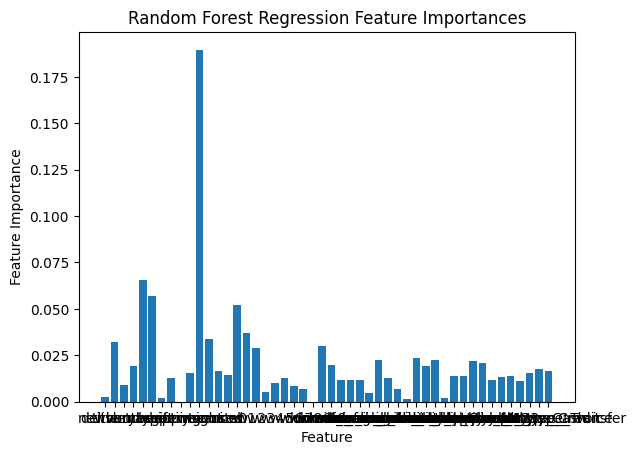

In [23]:
# Plot feature importance
fig = plt.figure()
ax = fig.gca() #get current axis
ax.bar(range(x_train.shape[1]), forest_cv2.best_estimator_.feature_importances_)
ax.set_xticks(np.arange(x_train.shape[1]))
ax.set_xticklabels([f'{col}' for col in x_train.columns])
ax.set_xlabel('Feature')
ax.set_ylabel('Feature Importance')
ax.set_title('Random Forest Regression Feature Importances')

# Ugly ass graph but its working 

In [24]:
# Get feature importances with names 
importance = pd.DataFrame(forest_cv2.best_estimator_.feature_importances_)
feature_names = pd.DataFrame(x_train.columns)
feature_importances = pd.concat([importance, feature_names], axis = 1)

# Name columns accordingly
feature_importances.columns = ["Importance", "Feature"]
feature_importances.sort_values(by = "Importance", ascending = False)

,Importance,Feature
10,0.189702,weight
4,0.065349,case
5,0.056658,numberitems
14,0.052096,w0
15,0.037189,w1
11,0.033586,remi
1,0.032117,newsletter
23,0.030200,w9
16,0.029115,w2
33,0.023473,domain_others


In [25]:
# Now what to we do with this? Can we just leave out the worst 10 features for example? 
# Random forest not really useful in predicting true positives

---

### Ada Boost

In [26]:
ada = AdaBoostClassifier(n_estimators = 500, learning_rate = 0.8)
ada = ada.fit(x_train, y_train)

In [27]:
# Predict and evaluate 
# Training data
y_train_pred_ada = ada.predict(x_train)
# Test data
y_test_pred_ada = ada.predict(x_test)
# Evalute performance
evaluate_model(y_train, y_train_pred_ada, y_test, y_test_pred_ada)

,Set,Accuracy,Precision,Sensitivity,Specificity,TP,FP,TN,FN
0,Training,0.814001,0.624000,0.018340,0.997452,78,47,18399,4175
1,Test,0.813239,0.333333,0.010567,0.995209,19,38,7893,1779


In [28]:
# Setup ranges for different parameters for hyperparameter tuning
max_depth = range(1,5) 
n_estimators = range(10,50)
learning_rate = np.arange(0.5, 5, 0.25) # In Adaboost learning rate can go to infinity (weights of previous misclassifications)
#cv = range(4,10)

# What about depth of base estimator? 

# Collect in dictionary
param_dist = {'max_depth': max_depth, 'n_estimators': n_estimators, "learning_rate": learning_rate}

# Set up AdaBoost classifier
ada = AdaBoostClassifier()
# Set up RandomizedSearchCV
ada_cv = RandomizedSearchCV(ada, param_dist, n_jobs = -1, verbose = 1, n_iter = 1000, cv = 5, scoring = 'balanced_accuracy')
# Fit it to the data
ada_cv.fit(x_train,y_train) 

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


ValueError: Invalid parameter 'max_depth' for estimator AdaBoostClassifier(n_estimators=36). Valid parameters are: ['algorithm', 'base_estimator', 'estimator', 'learning_rate', 'n_estimators', 'random_state'].

In [ ]:
param_dist_ada = {
    'n_estimators': range(50, 200),
    'learning_rate': uniform(0.01, 0.3),
    'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)],
    'algorithm': ['SAMME', 'SAMME.R']
    
}

In [ ]:
# Get predictions from AdaCV model
y_train_pred_ada_cv = ada_cv.predict(x_train)
# Evaluate accuracy of cross-validated model
evaluate_model(y_train, y_train_pred_ada_cv)

Accuracy: 0.8134636733686937
Precision (Share of positives correctly specified): 0.625
Sensitivity (Share of actual true values found): 0.0008263097008758883
Specificity (Share of actual false values found): 0.9998862645486598
TP: 5 FP: 3 TN: 26374 FN: 6046


---

### XGBoost

In [29]:
# Setup parameter distributions for hyperparameter tuning
max_depth = range(1, 15)
n_estimators = range(20,40)
learning_rate = np.linspace(0.1, 0.9, 9)
param_dist = {"max_depth": max_depth, "n_estimators": n_estimators, "learning_rate": learning_rate}

# Set up GradientBoostingClassifier
xgb = XGBClassifier()
# Set up RandomizedSearchCV
xgb_cv = RandomizedSearchCV(xgb, param_dist, n_jobs = -1, cv = 5, verbose = 1, n_iter = 700, scoring = 'balanced_accuracy')
# Fit it to the data
xgb_cv.fit(x_train, y_train)

Fitting 5 folds for each of 700 candidates, totalling 3500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=700, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'max_depth': range(1, 15),
                                        'n_estimators': range(20, 40)},
                   scoring='balanced_accuracy', verbose=1)

In [ ]:
xgb_cv.best_params_

{'n_estimators': 32, 'max_depth': 14, 'learning_rate': 0.8}

In [ ]:
# Get predictions and evaluate model performance
# Get predictions for training data
y_train_pred_gbrt_cv = xgb_cv.predict(x_train)
# Get predictions for test data
y_test_pred_gbrt_cv = xgb_cv.predict(x_test)
# Evaluate model performance
evaluate_model(y_train, y_train_pred_gbrt_cv, y_test, y_test_pred_gbrt_cv)

,Set,Accuracy,Precision,Sensitivity,Specificity,TP,FP,TN,FN
0,Training,0.943698,0.975031,0.722814,0.995647,3124,80,18297,1198
1,Test,0.773461,0.232244,0.119144,0.914875,206,681,7319,1523


In [ ]:
# Test-wise save of the model
# joblib.dump(gbrt, "gbrt.joblib")

Gradient Boosting With XGBoost

XGBoost, which is short for “Extreme Gradient Boosting,” is a library that provides an efficient implementation of the gradient boosting algorithm.

The main benefit of the XGBoost implementation is computational efficiency and often better model performance.

For more on the benefits and capability of XGBoost, see the tutorial:


https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/